# 0. Trasnfer Learning  

- In this parctice, you will learn how to train a convolutional neural network for image classification using transfer learning. 

- We are going to focus on how to use the pre-trained models for trasnfer learning. The entire practices consists of the following main steps.

- Model Inference Process
 1. Load Data 
 2. Trainig the model 
 3. Finetuning the CNN 
 4. Save and Load model 
 5. CNN as fixed feature extractor Specify image transformations  
 

# 1. Load Data

- We will use torchvision and torch.utils.data packages for loading the data.

- The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

- This dataset is a very small subset of imagenet.

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/My Drive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

 - **(Optional) Visualize a few images** : Let’s visualize a few training images so as to understand the data augmentations.
 


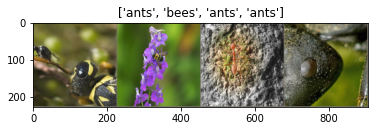

In [2]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 2. Training the model

- **Defining train_model function for a general function**. Here, we will illustrate:
 - Scheduling the learning rate
 - Saving the best model

- In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.


In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

 - **Visualizing the model predictions** : Generic function to display predictions for a few images

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#3. Finetuning the convnet

- Load a pretrained model and reset final fully connected layer.

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


 - **Train :** It should take around 15-25 min on CPU. On GPU though, it takes less than a minute

In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4643 Acc: 0.7541
val Loss: 0.2881 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.6354 Acc: 0.7459
val Loss: 0.5452 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.7434 Acc: 0.7295
val Loss: 0.2785 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.6365 Acc: 0.7664
val Loss: 0.4197 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.5649 Acc: 0.7582
val Loss: 0.2493 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.6121 Acc: 0.7623
val Loss: 0.2939 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.3465 Acc: 0.8238
val Loss: 0.2372 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3893 Acc: 0.8443
val Loss: 0.2207 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3618 Acc: 0.8484
val Loss: 0.2024 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3550 Acc: 0.8197
val Loss: 0.2273 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3083 Acc: 0.8852
val Loss: 0.1933 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4018 Acc: 0.8361
val Loss: 0.1892 Acc: 0.9346

Ep

- **Evaluate** : Let’s  display predictions for a few images

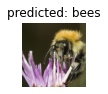

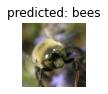

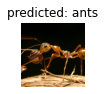

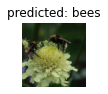

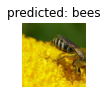

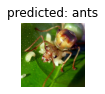

In [7]:
visualize_model(model_ft)

#4. Saving & Loading trained Model  
- When it comes to saving and loading models, there are three core functions to be familiar with:
 - torch.save: Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
 - torch.load: Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).
 - torch.nn.Module.load_state_dict: Loads a model’s parameter dictionary using a deserialized state_dict. For more information on state_dict, see What is a state_dict?.
 - For more details : https://pytorch.org/tutorials/beginner/saving_loading_models.html 

In [9]:
# Save model 
torch.save(model_ft.state_dict(), "model.pth")

# Load model 
model_ft.load_state_dict(torch.load("model.pth")) 

<All keys matched successfully>

#5. ConvNet as fixed feature extractor

- Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

- **Train and evaluate**
 - On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7592 Acc: 0.6230
val Loss: 0.2307 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5191 Acc: 0.7746
val Loss: 0.2736 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4796 Acc: 0.7746
val Loss: 0.1861 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4221 Acc: 0.7951
val Loss: 0.1837 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4022 Acc: 0.8320
val Loss: 0.1813 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4796 Acc: 0.7664
val Loss: 0.2111 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3223 Acc: 0.8525
val Loss: 0.2181 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3584 Acc: 0.8443
val Loss: 0.2052 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3995 Acc: 0.8402
val Loss: 0.2035 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4505 Acc: 0.8074
val Loss: 0.2039 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4094 Acc: 0.7951
val Loss: 0.2126 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3099 Acc: 0.8730
val Loss: 0.1859 Acc: 0.9412

Ep

 - **(Optional) Visualize a few images** : Let’s  display predictions for a few images

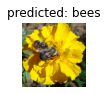

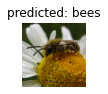

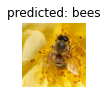

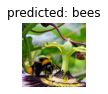

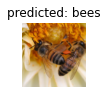

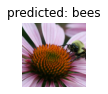

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# 6. References

- PyTorch : TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL
 - https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#further-learning